# Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import time
import pickle as pck
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression


# Load in dataset

In [47]:
df = pd.read_csv("../input/womens_input.csv")

/var/folders/3m/1391qbxd3jg3m15k2d19w9qw0000gn/T/ipykernel_61990/1906310488.py:1: DtypeWarning: Columns (32,37,39,43,76,81,83,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../input/womens_input.csv")


In [48]:
df.head()

,Unnamed: 0,TEAM,OVR_PERCENT,WINS,LOSSES,CONF_PERCENT,CONF_WINS,CONF_LOSSES,HOME_PERCENT,HOME_WINS,...,OPP_DBPI,OPP_BPIRK,OPP_SOR,OPP_SOR_SCURVE,OPP_SOS,OPP_NC_SOS,OPP_QUAL_WINS,OPP_QUAL_LOSSES,OPP_QUALITY_INDICATOR,OPP_SCORE
0,0,Austin Peay Governors,0.686,24,11,0.686,16.0,4.0,0.686,12.0,...,-1.6,49.0,26.0,26,81.0,243,4.0,5.0,1.777778,81
1,1,Austin Peay Governors,0.686,24,11,0.686,16.0,4.0,0.686,12.0,...,4.2,270.0,255.0,257,317.0,220,0.0,1.0,0.000000,49
2,2,Austin Peay Governors,0.686,24,11,0.686,16.0,4.0,0.686,12.0,...,-6.4,233.0,236.0,238,251.0,72,0.0,3.0,0.000000,78
3,3,Austin Peay Governors,0.686,24,11,0.686,16.0,4.0,0.686,12.0,...,8.0,3.0,3.0,3,76.0,7,10.0,2.0,8.333333,104
4,4,Austin Peay Governors,0.686,24,11,0.686,16.0,4.0,0.686,12.0,...,-7.9,208.0,222.0,224,265.0,102,0.0,4.0,0.000000,77


In [49]:
df = df.dropna()

# Predict Score

In [50]:
df.SCORE = df.SCORE.apply(pd.to_numeric, errors="coerce")
df.OPP_SCORE = df.OPP_SCORE.apply(pd.to_numeric, errors="coerce")

In [51]:
df = df.drop(columns=[
      "WINNER",
      "TEAM",
      "OPP_TEAM"])
df = pd.get_dummies(df, columns=['CONF', 'OPP_CONF'])
df = df[pd.to_numeric(df['OPP_NC_SOS'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['NC_SOS'], errors='coerce').notnull()]
# df['CONF'] = pd.Categorical(df.CONF)
# df['OPP_CONF'] = pd.Categorical(df.OPP_CONF)
df = df.dropna()
y = df[["SCORE", "OPP_SCORE"]]
x = df.drop(columns=["SCORE", "OPP_SCORE","FINAL_STREAK","OPP_FINAL_STREAK"])


KeyError: ('OPP_NC_SOS', 'NC_SOS')

In [44]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.1, random_state=31523)

In [45]:
start = time.time()

rf = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=10,
    bootstrap=True
)
rf.fit(train_x, train_y)

end = time.time()

ValueError: could not convert string to float: '--'

In [ ]:
### Random Forest
rf_pred = rf.predict(test_x)
rf_mae = mean_absolute_error(test_y, rf_pred)
print(f"{'Random Forest MAE:':<20} ==> {rf_mae}")

Random Forest MAE:   ==> 7.820567322160073


In [ ]:
### ANN
ann = MLPRegressor(hidden_layer_sizes = (10,50,10))
ann.fit(train_x, train_y)

MLPRegressor(hidden_layer_sizes=(10, 50, 10))

In [ ]:
### ANN
ann_pred = ann.predict(test_x)
ann_mae = mean_absolute_error(test_y, ann_pred)
print(f"{'Neural Net MAE:':<20} ==> {ann_mae}")

Neural Net MAE:      ==> 7.690971227598872


In [ ]:
# Linear Regression
lin = LinearRegression()
lin.fit(train_x, train_y)

LinearRegression()

In [ ]:
lin_pred = lin.predict(test_x)
lin_acc = lin.score(test_x, test_y)
lin_mae = mean_absolute_error(test_y, lin_pred)
print(f"{'Linear Regression MAE:':<20} ==> {lin_mae}")
print(f"{'Linear Regression (r-squared)':<20} ==> {lin_acc}")

Linear Regression MAE: ==> 7.652179265231661
Linear Regression (r-squared) ==> 0.3958560126986219


In [ ]:
# Feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

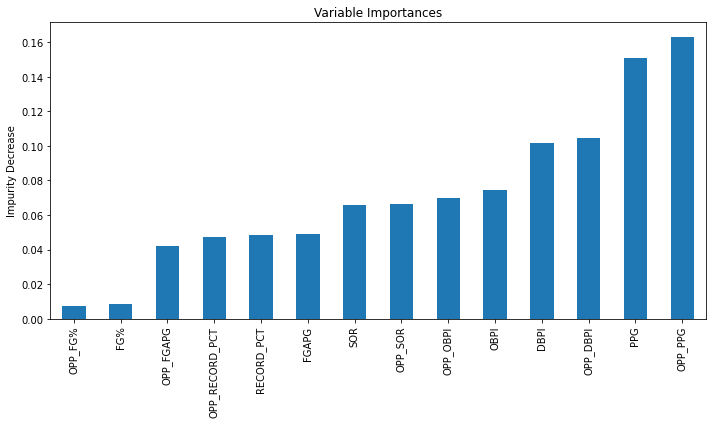

In [ ]:
feature_names = list(x for x in df.columns if "SCORE" not in x)
forest_importances = pd.Series(importances, index=feature_names).sort_values()
fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Variable Importances")
ax.set_ylabel("Impurity Decrease")
fig.tight_layout()

In [ ]:
def analyze_predicted_scores(predictions, actual_scores):
    total_scores = len(predictions)
    if total_scores != len(actual_scores):
        print("Array lengths don't line up!")
        return -1
    correct = 0
    for i in range(total_scores):
        pred = predictions[i]
        score = actual_scores[i]
        if pred[0] > pred[1] and score[0] > score[1] or \
            pred[0] < pred[1] and score[0] < score[1]:
            correct += 1
            
    return correct/total_scores

In [ ]:
analyze_predicted_scores(lin_pred, test_y.to_numpy())

0.745216578373325

In [ ]:
analyze_predicted_scores(rf_pred, test_y.to_numpy())

0.7504518541601745

In [ ]:
analyze_predicted_scores(ann_pred, test_y.to_numpy())

0.7497039576191961

# Selected Model

In [ ]:
with open("ann_scores.pck", 'wb') as f:
    pck.dump(ann, f)
    
with open("lin_scores.pck", 'wb') as f:
    pck.dump(lin, f)